<div>
  <h1 align="center">Trabalho de Deep Learning</h1>
  <div align="center">Lucas de Almeida, RA: 1996762</div>
  <div align="center">Vinícius Augusto de Souza, RA: 1997530</div>
  <hr/>
  <div align="center">Uma abordagem dos conceitos de redes neurais convolucionais pré treinadas utilizando o método de <i>transfer learning</i>.
</div>
  <div align="center">A base de dados a ser utilizada será a <i>Basic Shapes</i>, que pode ser encontrada <a href="https://www.kaggle.com/cactus3/basicshapes">neste link</a>. Ela é bem simples e objetiva, contendo um acervo de 300 imagens: 100 imagens de cada forma geométrica (circulos, quadrados e triangulos) desenhados manualmente por <a href="https://www.kaggle.com/cactus3">Mark S.</a></div>
</div>
<hr/>

<h3>Considerações sobre o trabalho:</h3>
<hr/>
<p>Para o desenvolvimento deste trabalho, foi escolhido o modelo pré-treinado da literatura <i><a href="https://keras.io/api/applications/xception/">Xception</a></i>, considerando os pesos também pré treinados da <i>ImageNet</i>.</p>


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import os
import random
from tqdm import tqdm
import shutil
import pathlib

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


<h3>Separação dos arquivos:</h3>
<hr>
<div>Antes de começar a tratar os dados, é necessário realizar a divisão do dataset em 80% para treino e 20% para testes.</div>
<div>O código a seguir realiza essa tarefa, passando como variáveis:</div>
<ul>
    <li><i>data_dir</i>: o nome do caminho do diretório do dataset escolhido;</li>
    <li><i>classes</i>: as classes das quais os arquivos pertencem (circulos, quadrados e triângulos);</li>
    <li><i>output_dir</i>: o nome do caminho do diretório de saída, após separação;</li>
    <li><i>ratio</i>: a taxa de divisão dos arquivos (i.e. 80% treino e 20% testes);</li>
</ul>
<p>Em seguida são carregadas essas variávies e todas as imagens <i>.png</i> são selecionadas e armazenadas na variável <i>file</i>.</p>
<p>Em seguida, é escolhida uma <i>seed</i> arbitrária para embaralhar as imagens de forma que seja possível reproduzir essa mesma divisão posteriormente. Os arquivos então são embaralhados e divididos conforme os parâmetros passados anteriormente.</p>
<p>Por fim, os arquivos divididos são enviados cada um para seu respectivo diretório, treino ou teste, e sempre divididos em pastas referentes à sua classe, conforme a estrutura a seguir:</p>
<ul>
    <li><i>test</i> <span  style="color:lightgrey">(80% do dataset)</span></li>
    <ul>
        <li><i>circles</i></li>
        <li><i>triangles</i></li>
        <li><i>squares</i></li>
    </ul>
    <li><i>train</i> <span  style="color:lightgrey">(20% do dataset)</span></li>
    <ul>
        <li><i>circles</i></li>
        <li><i>triangles</i></li>
        <li><i>squares</i></li>
    </ul>
    
</ul>

In [2]:
data_dir = "shapes"
classes = ["circles", "squares", "triangles"]
output_dir = "shapes_split"
ratio = [0.8, 0.2]

def split(data_dir, output_dir, ratio):
    for cell in classes:
        cell_path = os.path.join(data_dir, cell)
        files = os.listdir(cell_path)
        files = [os.path.join(cell_path, f) for f in files if f.endswith('.png')]

        random.seed(230)
        files.sort()
        random.shuffle(files)

        split_train = int(ratio[0] * len(files))
        split_test = split_train

        files_train = files[:split_train]
        files_test = files[split_test:]
        files_type = [(files_train, "train"), (files_test, "test")]

        for (files, folder_type) in files_type:
            full_path = os.path.join(output_dir, folder_type)
            full_path = os.path.join(full_path, cell)
            pathlib.Path(full_path).mkdir(parents=True, exist_ok=True)
            for f in files:
                shutil.copy2(f, full_path)

<h3>Definição dos parâmetros do modelo:</h3>
<hr>
<div>Antes de prosseguir, é necessário compreender em quais parâmetros o modelo se baseia. Dois desses parâmetros terão de ser definidos neste momento, os quais são:</div>
<ul>
    <li><i>epochs</i>: quantas vezes o algoritmo de treino será executado;</li>
    <li><i>batch size</i>: quantas amostras serão carregadas a cada uma dessas execuções.</li>
</ul>
<div>Para o treinamento, foi definido que seriam utilizadas 500 <i>epochs</i> e 32 como <i>batch size</i>.</div>

In [3]:
epochs = 500
batch = 32

<h3>Carregamento do modelo "<i>Xception</i>":</h3>
<hr>
<div>Primeiramente o modelo escolhido é carregado juntamente com os pesos aprendidos durante o treino (sem a camada densa) para a variável <i>base_model</i>. Em seguida, a variável <i>x</i> recebe a saída do modelo carregado.</div>

In [4]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False)

83689472/83683744 [==============================] - 15s 0us/step


In [5]:
x=base_model.output

<h3>Configuração do modelo "<i>Xception</i>":</h3>
<hr />
<div>
  Nesta etapa é necessário adicionar algumas camadas de nós. Para explicar o que
  ocorre em cada uma das camadas, é preciso observá-las uma a uma, conforme
  descrito abaixo:
</div>
<ul>
  <li>
    <i>camada GlobalMaxPooling</i>: Para reduzir a resolução, é utilizada uma
    operação de <i>pooling</i> conhecida como “<i>pooling máximo</i>” (ou
    <i>max pooling</i>). Nesta operação de agrupamento, um “bloco” com altura
    'A' e largura 'L' desliza sobre os dados de entrada (conforme na figura
    abaixo, de 'a' até 'd'). A cada iteração (ou seja, o quanto ela avança
    durante a operação de deslizamento) é muitas vezes igual ao tamanho da
    <i>pool</i>, de modo que seu efeito é igual a uma redução na altura e
    largura. Para cada bloco, ou “pool”, a operação envolve simplesmente o
    cálculo do valor máximo. Fazendo isso para cada pool, obtemos um resultado
    bem reduzido, otimizando muito a quantidade de espaço de que precisamos.
  </li>
  <img src="max-pooling.png" width="500" />
  <br /><br />
  <li>
    camada densa com função de ativação "<i>ReLU</i>": A função de ativação
    linear retificada (ou <i>ReLU</i>) é uma função linear por partes que
    produzirá a entrada diretamente se for positiva, caso contrário, ela
    produzirá zero. Ela se comporta conforme o gráfico abaixo:
    <br />
    <img src="relu.jpg" width="500" />
    Neste caso, foram adicionadas três camadas densas deste tipo, porém uma com
    128 neurônios, outra com 64 neurônios e outra com 32 neurônios.
    <br />
  </li>
  <li>
    <i>camada dropout</i>: é feita uma espécide de "regularização", onde alguns
    neurônios são desligados de forma aleatória, juntamente com suas conexões,
    apenas durante o período de treinamento, porém durante a predição todos os
    neurônios são mantidos ativos. O motivo de se fazer isso é evitar
    <i>overfitting</i> no treinamento. A porcentagem escolhida nesse caso foi de
    50%, conforme orientação no enunciado do projeto.
  </li>
  <li>
    <i>camada de ativação</i>: utiliza uma função de ativação ao final das camadas anteriores. Essa função tenta aplicar um comportamento biologicamente análogo às excitações dos neurônios reais, isto é, replicar o comportamento de transmissão de informações dos neurônios, que só conseguem passar adiante a informação após sofrerem um estímulo. O que ocorre na prática é que a função insere um comportamento de "não-linearidade" após a função dos pesos com as entradas. Conforme enunciado, teria de ser feita uma escolha entre a função <i>sigmóide</i> e a função <i>softmax</i>. A escolha nesta situação é intuitiva, pois a função sigmóid é mais utilizada no aprendizado de funções lógicas, uma vez que ela tenta encaixar os valores entre 0 e 1. Já a função softmax produz uma distribuição de probabilidades para cada uma das classes das imagens durante a classificação, ao contrário da sigmóid que só consegue lidar com duas classes. Sendo assim, fica definido então que a função a ser utilizada é a <i>softmax</i> com 3 classes.
  </li>
</ul>

<div>
  Em seguida é feita a definição do modelo final bem como sua exibição, que pode
  ser vista na sumário a seguir:
</div>
<span style="color: lightgrey"
  >Obs.: em virtude do tamanho do sumário, a linha de código que o exibe foi
  comentada.</span
>


In [6]:
x=tf.keras.layers.GlobalMaxPooling2D()(x)

x=tf.keras.layers.Dense(128,activation='relu')(x)

x=tf.keras.layers.Dense(64,activation='relu')(x)

x=tf.keras.layers.Dense(32,activation='relu')(x)

x=tf.keras.layers.Dropout(0.5)(x)

preds=tf.keras.layers.Dense(3,activation='softmax')(x)

model=tf.keras.models.Model(inputs=base_model.input,outputs=preds)

#model.summary()

<h3>Treinamento e teste do modelo:</h3>
<hr />
<div>
  Primeiramente, é feito o congelamento dos neurônios já treinados na
  <i>ImageNet</i>, para retreinar somente as camadas densas incluídas no passo
  anterior. Para fazer isso, é feita a mudança na variável booleana
  "<i>treinable</i>" de cada camada que não inicia com o nome "<i>dense</i>"
  para false.
</div>
<br/>
<div>
  Em seguida são criados dois objetos:
  <ul>
    <li><i>train_data_gen</i>;</li>
    <li><i>test_data_gen</i>.</li>
  </ul>
  Cada um desses objetos irá receber as imagens já processadas com o método da <i>ResNetV2</i>, separados em treino e teste conforme a nomenclatura da variável.
</div>
<br/>
<div>
  Posteriormente, é necessário criar os geradores das imagens (tanto de teste quanto de treino). Isso é feito atravez dos objetos criados anteriormente, através da função "<i>flow_from_directory</i>". Seus parâmetros são os que seguem:
  <ul>
    <li><i>path</i>: o caminho do diretório onde estão localizadas as imagens;</li>
    <li><i>target_size</i>: o tamanho da imagem (neste caso, foi escolhido o tamanho 128x128);</li>
    <li><i>batch_size</i>: o mesmo explicado anteriormente, que já foi definido como 32;</li>
    <li><i>class_mode</i>: pode ser "input", caso a imagem de entrada e saída forem as mesmas, "binary" se existirem apenas duas classes para realizar a predição ou "categorical", caso hajam mais classes, que é este caso;</li>
    <li><i>shuffle</i>: <i>booleano</i> para ativar ou não o embaralhamento da ordem das imagens que seram utilizadas.</li>
  </ul>
  O resultado obtido são dois geradores como saída, armazenados nos objetos:
  <ul>
    <li><i>train_generator</i>;</li>
    <li><i>test_generator</i>.</li>
  </ul>
</div>
<br/>
<div>
  Com os geradores criados, é preciso definir o otimizador. Conforme enunciado, os otimizadores que apresentam melhores resultados são o <i>SGD</i> e o <i>Adam</i>. Sendo assim, foi escolhido o <i>Adam</i>. Sendo assim, foi compilado o modelo com esses parâmetros, juntamente com a métrica escolhida como sendo por acurácia (<i>accuracy</i>), conforme orientação do enunciado.
</div>
</div>
<br />
<div>Por fim foram definidos os steps, e o modelo foi efetivamente treinado e testado. Os resultados podem ser vistos nos próximos tópicos.</div>



In [7]:
for l in model.layers:
    if l.name.split('_')[0] != 'dense':
        l.trainable=False
    else:
        l.trainable=True

In [8]:
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input) 

test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [9]:
train_generator = train_data_gen.flow_from_directory('shapes_split/train',
                                                 target_size=(128, 128), # tamanho da imagem para o generator                                                  
                                                 batch_size=batch,
                                                 class_mode='categorical',
                                                 shuffle=True)

test_generator = test_data_gen.flow_from_directory('shapes_split/test',
                                                 target_size=(128, 128), # tamanho da imagem para o generator                                                  
                                                 batch_size=batch,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [10]:
lr = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=lr, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
step_size_train = train_generator.n//train_generator.batch_size
step_size_test = test_generator.n//test_generator.batch_size

In [12]:
history = model.fit(train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=epochs,
                   validation_data=test_generator,
                   validation_steps=step_size_test)

Epoch 1/500
7/7 [==============================] - 15s 2s/step - loss: 0.7351 - accuracy: 0.6114 - val_loss: 0.0860 - val_accuracy: 1.0000
Epoch 2/500
7/7 [==============================] - 9s 1s/step - loss: 0.1160 - accuracy: 0.9701 - val_loss: 0.0206 - val_accuracy: 1.0000
Epoch 3/500
7/7 [==============================] - 9s 1s/step - loss: 0.0213 - accuracy: 0.9945 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 4/500
7/7 [==============================] - 9s 1s/step - loss: 0.0506 - accuracy: 0.9892 - val_loss: 0.0198 - val_accuracy: 1.0000
Epoch 5/500
7/7 [==============================] - 9s 1s/step - loss: 0.0182 - accuracy: 0.9872 - val_loss: 0.0253 - val_accuracy: 1.0000
Epoch 6/500
7/7 [==============================] - 9s 1s/step - loss: 0.0176 - accuracy: 0.9899 - val_loss: 0.0209 - val_accuracy: 1.0000
Epoch 7/500
7/7 [==============================] - 10s 1s/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0324 - val_accuracy: 1.0000
Epoch 8/500
7/7 [===============

7/7 [==============================] - 9s 1s/step - loss: 0.0088 - accuracy: 0.9950 - val_loss: 0.1201 - val_accuracy: 0.9688
Epoch 60/500
7/7 [==============================] - 9s 1s/step - loss: 0.0078 - accuracy: 0.9988 - val_loss: 0.1276 - val_accuracy: 0.9688
Epoch 61/500
7/7 [==============================] - 8s 1s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0587 - val_accuracy: 0.9688
Epoch 62/500
7/7 [==============================] - 8s 1s/step - loss: 0.0080 - accuracy: 0.9972 - val_loss: 0.0180 - val_accuracy: 1.0000
Epoch 63/500
7/7 [==============================] - 9s 1s/step - loss: 0.0070 - accuracy: 0.9945 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 64/500
7/7 [==============================] - 9s 1s/step - loss: 2.2072e-04 - accuracy: 1.0000 - val_loss: 7.1074e-06 - val_accuracy: 1.0000
Epoch 65/500
7/7 [==============================] - 8s 1s/step - loss: 3.9004e-04 - accuracy: 1.0000 - val_loss: 6.3383e-04 - val_accuracy: 1.0000
Epoch 66/500
7/7 [======

Epoch 116/500
7/7 [==============================] - 8s 1s/step - loss: 3.7921e-04 - accuracy: 1.0000 - val_loss: 1.1176e-08 - val_accuracy: 1.0000
Epoch 117/500
7/7 [==============================] - 8s 1s/step - loss: 1.4051e-05 - accuracy: 1.0000 - val_loss: 2.1715e-04 - val_accuracy: 1.0000
Epoch 118/500
7/7 [==============================] - 8s 1s/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 5.8685e-05 - val_accuracy: 1.0000
Epoch 119/500
7/7 [==============================] - 8s 1s/step - loss: 2.1905e-05 - accuracy: 1.0000 - val_loss: 7.4506e-09 - val_accuracy: 1.0000
Epoch 120/500
7/7 [==============================] - 8s 1s/step - loss: 7.2112e-04 - accuracy: 1.0000 - val_loss: 5.5383e-05 - val_accuracy: 1.0000
Epoch 121/500
7/7 [==============================] - 9s 1s/step - loss: 9.5273e-04 - accuracy: 1.0000 - val_loss: 1.5763e-04 - val_accuracy: 1.0000
Epoch 122/500
7/7 [==============================] - 8s 1s/step - loss: 0.0043 - accuracy: 0.9988 - val_loss: 4.3730

7/7 [==============================] - 8s 1s/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 5.3640e-06 - val_accuracy: 1.0000
Epoch 173/500
7/7 [==============================] - 8s 1s/step - loss: 2.1385e-04 - accuracy: 1.0000 - val_loss: 4.6938e-07 - val_accuracy: 1.0000
Epoch 174/500
7/7 [==============================] - 9s 1s/step - loss: 4.5239e-05 - accuracy: 1.0000 - val_loss: 4.1832e-06 - val_accuracy: 1.0000
Epoch 175/500
7/7 [==============================] - 9s 1s/step - loss: 0.0035 - accuracy: 0.9982 - val_loss: 4.1050e-06 - val_accuracy: 1.0000
Epoch 176/500
7/7 [==============================] - 8s 1s/step - loss: 4.4429e-05 - accuracy: 1.0000 - val_loss: 4.3211e-06 - val_accuracy: 1.0000
Epoch 177/500
7/7 [==============================] - 8s 1s/step - loss: 0.0136 - accuracy: 0.9919 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 178/500
7/7 [==============================] - 8s 1s/step - loss: 4.9721e-05 - accuracy: 1.0000 - val_loss: 3.5426e-06 - val_accurac

7/7 [==============================] - 9s 1s/step - loss: 6.2113e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 229/500
7/7 [==============================] - 11s 2s/step - loss: 8.4856e-04 - accuracy: 1.0000 - val_loss: 1.6414e-04 - val_accuracy: 1.0000
Epoch 230/500
7/7 [==============================] - 10s 1s/step - loss: 9.1117e-04 - accuracy: 1.0000 - val_loss: 6.1168e-05 - val_accuracy: 1.0000
Epoch 231/500
7/7 [==============================] - 8s 1s/step - loss: 4.0922e-05 - accuracy: 1.0000 - val_loss: 2.7922e-05 - val_accuracy: 1.0000
Epoch 232/500
7/7 [==============================] - 10s 1s/step - loss: 0.0046 - accuracy: 0.9952 - val_loss: 1.8651e-05 - val_accuracy: 1.0000
Epoch 233/500
7/7 [==============================] - 9s 1s/step - loss: 8.7942e-04 - accuracy: 1.0000 - val_loss: 2.3282e-06 - val_accuracy: 1.0000
Epoch 234/500
7/7 [==============================] - 9s 1s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.2798e-06 - val_

7/7 [==============================] - 8s 1s/step - loss: 1.8968e-05 - accuracy: 1.0000 - val_loss: 3.7242e-05 - val_accuracy: 1.0000
Epoch 285/500
7/7 [==============================] - 9s 1s/step - loss: 2.2840e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 286/500
7/7 [==============================] - 9s 1s/step - loss: 1.1667e-04 - accuracy: 1.0000 - val_loss: 1.4458e-04 - val_accuracy: 1.0000
Epoch 287/500
7/7 [==============================] - 8s 1s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 3.8328e-05 - val_accuracy: 1.0000
Epoch 288/500
7/7 [==============================] - 8s 1s/step - loss: 8.9395e-07 - accuracy: 1.0000 - val_loss: 3.8615e-05 - val_accuracy: 1.0000
Epoch 289/500
7/7 [==============================] - 8s 1s/step - loss: 5.3909e-05 - accuracy: 1.0000 - val_loss: 1.5438e-04 - val_accuracy: 1.0000
Epoch 290/500
7/7 [==============================] - 10s 1s/step - loss: 5.5985e-05 - accuracy: 1.0000 - val_loss: 1.5180e-04 - va

Epoch 340/500
7/7 [==============================] - 11s 2s/step - loss: 0.0046 - accuracy: 0.9950 - val_loss: 8.5710e-05 - val_accuracy: 1.0000
Epoch 341/500
7/7 [==============================] - 12s 2s/step - loss: 0.0099 - accuracy: 0.9889 - val_loss: 6.1518e-05 - val_accuracy: 1.0000
Epoch 342/500
7/7 [==============================] - 13s 2s/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 5.6592e-05 - val_accuracy: 1.0000
Epoch 343/500
7/7 [==============================] - 12s 2s/step - loss: 9.3293e-04 - accuracy: 1.0000 - val_loss: 7.8966e-06 - val_accuracy: 1.0000
Epoch 344/500
7/7 [==============================] - 14s 2s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 5.2188e-05 - val_accuracy: 1.0000
Epoch 345/500
7/7 [==============================] - 12s 1s/step - loss: 1.1344e-05 - accuracy: 1.0000 - val_loss: 7.2635e-06 - val_accuracy: 1.0000
Epoch 346/500
7/7 [==============================] - 10s 1s/step - loss: 8.7712e-05 - accuracy: 1.0000 - val_loss: 5.2854e

7/7 [==============================] - 9s 1s/step - loss: 2.1709e-05 - accuracy: 1.0000 - val_loss: 2.4206e-05 - val_accuracy: 1.0000
Epoch 397/500
7/7 [==============================] - 10s 1s/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 398/500
7/7 [==============================] - 9s 1s/step - loss: 9.9420e-04 - accuracy: 0.9988 - val_loss: 2.4295e-05 - val_accuracy: 1.0000
Epoch 399/500
7/7 [==============================] - 9s 1s/step - loss: 2.7647e-04 - accuracy: 1.0000 - val_loss: 1.2554e-06 - val_accuracy: 1.0000
Epoch 400/500
7/7 [==============================] - 10s 1s/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 2.7065e-05 - val_accuracy: 1.0000
Epoch 401/500
7/7 [==============================] - 9s 1s/step - loss: 0.0015 - accuracy: 0.9981 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 402/500
7/7 [==============================] - 9s 1s/step - loss: 3.4708e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accur

7/7 [==============================] - 10s 1s/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 9.8332e-06 - val_accuracy: 1.0000
Epoch 453/500
7/7 [==============================] - 10s 1s/step - loss: 0.0172 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 454/500
7/7 [==============================] - 12s 2s/step - loss: 3.1027e-07 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 455/500
7/7 [==============================] - 15s 2s/step - loss: 0.0043 - accuracy: 0.9964 - val_loss: 6.7718e-06 - val_accuracy: 1.0000
Epoch 456/500
7/7 [==============================] - 17s 2s/step - loss: 3.3094e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 457/500
7/7 [==============================] - 12s 2s/step - loss: 1.0339e-04 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 458/500
7/7 [==============================] - 9s 1s/step - loss: 6.4854e-06 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0

In [13]:
loss_train, train_acc = model.evaluate(train_generator, steps=step_size_train)
loss_test, test_acc = model.evaluate(test_generator, steps=step_size_test)
print('Acurácia de treino: %.3f ' % (train_acc))
print('Acurácia de teste: %.3f ' % (test_acc))

1/1 [==============================] - 1s 880ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acurácia de treino: 1.000 
Acurácia de teste: 1.000 



<div>
  Observando os números acima para a acurácia, podemos ver que o resultado foi um número muito atípico, no caso <i>1.000</i>, que representa 100% de acurácia no treino e no teste. Quando isso acontece, geralmente se dá o nome de <i>overfit</i> (ou <i>overfitting</i>), que é quando um modelo estatístico se ajusta bem demais ao conjunto de dados observado, mas se mostra ineficaz para prever novos resultados. Os gráficos abaixo ilustram bem esse comportamento:
<img src="https://miro.medium.com/max/1125/1*_7OPgojau8hkiPUiHoGK_w.png" width="700"/>
</div>
<br/>
<div>
  O gráfico seguinte apresenta a taxa de perda de treino e de teste:
</div>

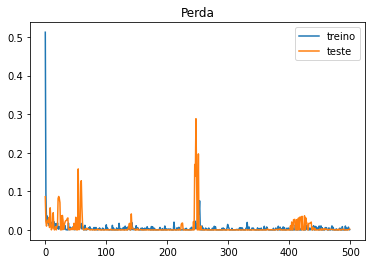

In [14]:
plt.title('Perda')
plt.plot(history.history['loss'], label='treino')
plt.plot(history.history['val_loss'], label='teste')
plt.legend()
plt.show()

O gráfico seguinte apresenta a acurácia de treino e de teste:

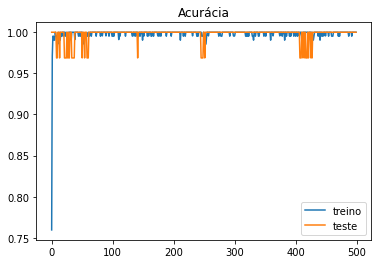

In [15]:
plt.title('Acurácia')
plt.plot(history.history['accuracy'], label='treino')
plt.plot(history.history['val_accuracy'], label='teste')
plt.legend()
plt.show()

Por fim, são feitas as classificações finais, onde são criadas as estruturas para as métricas de avaliação.

In [16]:
print('Criando classificações..')
labels = os.listdir('shapes_split/test')
print('Rótulos', labels)
#criando estruturas para métricas de avaliação, processo um pouco mais demorado
Y_pred = model.predict_generator(test_generator)
print('Preds Created')
y_pred = np.argmax(Y_pred, axis=1)
print('Preds 1D created')

Criando classificações..
Rótulos ['circles', 'squares', 'triangles']


c:\users\lucas\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Preds Created
Preds 1D created


Podemos observar as classificações finais, divididas em:

----------------CLASSIFICATION--------------
              precision    recall  f1-score   support

     circles       0.30      0.30      0.30        20
     squares       0.40      0.40      0.40        20
   triangles       0.40      0.40      0.40        20

    accuracy                           0.37        60
   macro avg       0.37      0.37      0.37        60
weighted avg       0.37      0.37      0.37        60

----------------MATRIX--------------


<AxesSubplot:>

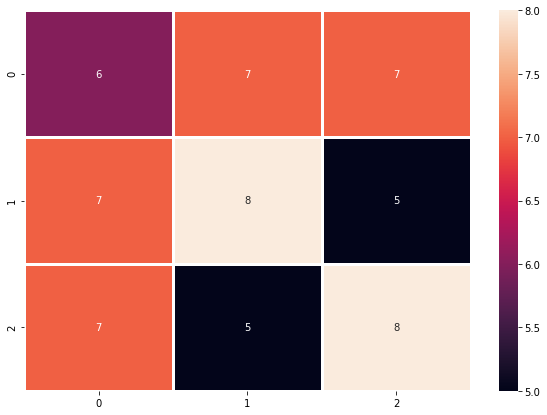

In [17]:
classification = classification_report(test_generator.classes, y_pred, target_names=labels)
print('----------------CLASSIFICATION--------------')
print(classification)
matrix = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(matrix, index = [i for i in range(3)],
                  columns = [i for i in range(3)])
plt.figure(figsize = (10,7))
print('----------------MATRIX--------------')
sn.heatmap(df_cm, annot=True, linewidths=2.5)

<h3>Referências bibliográficas:</h3>
<hr />
<div>
<p>https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/</p>
    
<p>https://www.viceri.com.br/insights/arquiteturas-de-redes-neurais-convolucionais-para-reconhecimento-de-imagens/</p>

<p>https://abracd.org/overfitting-e-underfitting-em-machine-learning/</p>
</div>